In [27]:
"""Librairies nécessaires"""
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [28]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-Stat-App-2A')

In [157]:
"""Emplacement des fichiers dvf"""

emplacement_dvf_base = '1.2) Données_concat/dvf_concat_2021_to_2023.geojson'

emplacement_dvf_parcs = '3.1) Données_enrichies/dvf_concat_2021_to_2023_avec_parcs.geojson'
emplacement_dvf_lycees = '3.1) Données_enrichies/dvf_concat_2021_to_2023_avec_lycees.geojson'
emplacement_dvf_sites_tour = '3.1) Données_enrichies/dvf_concat_2021_to_2023_avec_sites_tour.geojson'
emplacement_dvf_transports = '3.1) Données_enrichies/dvf_concat_2021_to_2023_avec_transports.geojson'
emplacement_dvf_log_sociaux = '3.1) Données_enrichies/dvf_concat_2021_to_2023_avec_log_sociaux.geojson'

In [158]:
"""Lecture des fichiers"""

dvf_base = gpd.read_file(emplacement_dvf_base)

dvf_avec_lycees = gpd.read_file(emplacement_dvf_lycees)
dvf_avec_parcs = gpd.read_file(emplacement_dvf_parcs)
dvf_avec_sites_tour = gpd.read_file(emplacement_dvf_sites_tour)
dvf_avec_transports = gpd.read_file(emplacement_dvf_transports)
dvf_avec_log_sociaux = gpd.read_file(emplacement_dvf_log_sociaux)

In [160]:
"""vérification des dimensions des fichiers"""

num_rows_base = dvf_base.shape[0]

# Utilisation de l'instruction assert pour vérifier que tous les GeoDataFrames ont le même nombre de lignes
assert all(df.shape[0] == num_rows_base for df in [dvf_avec_lycees, dvf_avec_parcs, dvf_avec_sites_tour, dvf_avec_transports, dvf_avec_log_sociaux]), "Les GeoDataFrames n'ont pas le même nombre de lignes."

# Si l'instruction assert réussit, cela signifie que tous les GeoDataFrames ont le même nombre de lignes
print("Tous les GeoDataFrames ont le même nombre de lignes.")

Tous les GeoDataFrames ont le même nombre de lignes.


In [161]:
# Création d'un DataFrame final en copiant dvf_base
dvf_final = dvf_base.copy()

# Liste des GeoDataFrames à ajouter
dataframes_to_add = [
    dvf_avec_lycees,
    dvf_avec_parcs,
    dvf_avec_sites_tour,
    dvf_avec_transports,
    dvf_avec_log_sociaux
]

# Ajout des colonnes des autres GeoDataFrames à dvf_final
for df_to_add in dataframes_to_add:
    # Colonnes à ajouter (qui ne sont pas déjà présentes dans dvf_final)
    columns_to_add = df_to_add.columns.difference(dvf_final.columns)
    
    # Ajout des colonnes
    dvf_final = pd.concat([dvf_final, df_to_add[columns_to_add]], axis=1)


In [162]:
#vérification de la taille du dataframe
print(dvf_final.shape)
print(dvf_avec_log_sociaux.shape)

(59417, 30)
(59417, 21)


In [163]:
dvf_final.isnull().sum()

id_mutation                  0
date_mutation                0
prix                         0
log_prix                     0
nombre_pieces_principales    0
surface_reelle_bati          0
surface_carrez               0
nombre_dependances           0
prix_au_m2_carrez            0
prix_au_m2_reel_bati         0
adresse_numero               7
adresse_nom_voie             0
code_postal                  0
code_commune                 0
nom_arrondissement           0
num_arrondissement           0
nom_quartier                 0
longitude                    0
latitude                     0
geometry                     0
closest_lycee                0
dist_min_lycee               0
dist_min_parc                0
nom_esp_vert_proche          0
closest_site_tour            0
dist_min_site_tour           0
closest_stat                 0
dist_min_stat                0
num_ligne                    0
dist_min_log_social          0
dtype: int64

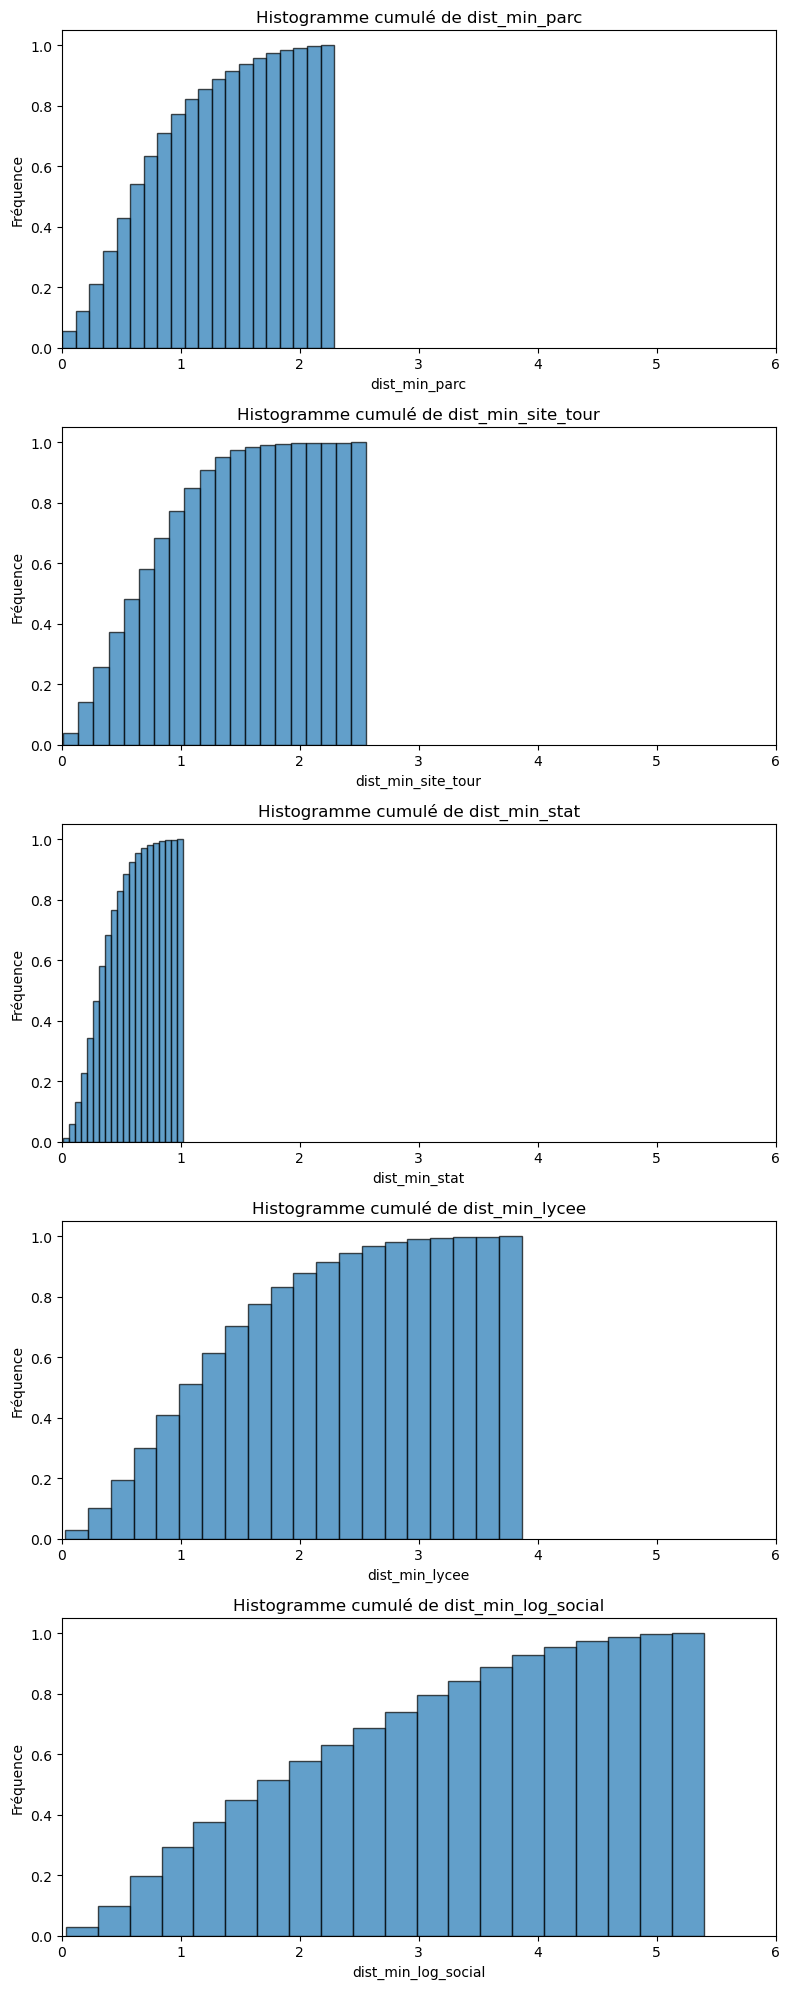

In [164]:
"""Histogrammes distances"""

liste_var_dist = ['dist_min_parc', 'dist_min_site_tour', 'dist_min_stat', 'dist_min_lycee', 'dist_min_log_social']

# Créer une figure et des sous-plots
fig, axes = plt.subplots(nrows=len(liste_var_dist), ncols=1, figsize=(8, 4 * len(liste_var_dist)))

# Initialiser une plage commune pour l'axe x
x_range = (0, 6)  # Ajustez selon vos besoins

# Boucle pour créer les histogrammes
for i, variable in enumerate(liste_var_dist):
    # Créer un histogramme de l'effectif cumulé
    axes[i].hist(dvf_final[variable], bins=20, edgecolor='black', alpha=0.7, density=True, cumulative=True)

    # Ajouter des étiquettes et un titre
    axes[i].set_xlabel(f'{variable}')
    axes[i].set_ylabel('Fréquence')
    axes[i].set_title(f'Histogramme cumulé de {variable}')

    # Définir la plage commune pour l'axe x
    axes[i].set_xlim(x_range)

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher les histogrammes
plt.show()

In [165]:
"""Ajout des indicatrices de proximité"""

#les variables de distance
liste_colonnes_distance = ['dist_min_parc', 'dist_min_site_tour', 'dist_min_stat', 'dist_min_lycee', 'dist_min_log_social']

#noms des nouvelles colonnes
dic_nouv_nom = {'dist_min_parc': 'ind_proxi_parc', 'dist_min_site_tour':'ind_proxi_site_tour',
    'dist_min_stat':'ind_proxi_stat', 'dist_min_lycee':'ind_proxi_lycee', 'dist_min_log_social':'ind_proxi_log_social'}

#définition du critère de proximité (en km) selon les variables
dic_borne_proxi = {'dist_min_parc': 0.15, 'dist_min_site_tour':0.2,
    'dist_min_stat':0.15, 'dist_min_lycee':0.35, 'dist_min_log_social':0.6}

#fonction qui ajoute les indicatrices
def ajouter_indicatrices_proximité(dvf, colonnes):

    for colonne in colonnes:
        nom_nouvelle_colonne = dic_nouv_nom[colonne]
        dvf[nom_nouvelle_colonne] = dvf.apply(lambda row: 1 if row[colonne] < dic_borne_proxi[colonne] else 0, axis=1)
        
    return dvf

In [166]:
dvf_final = ajouter_indicatrices_proximité(dvf_final, liste_colonnes_distance)

In [167]:
"""On regarde les proportions associées aux variables indicatrices"""

proportions = dvf_final[liste_var_ind_dist].apply(lambda col: col.value_counts(normalize=True)).reset_index()
print(proportions)

   index  ind_proxi_parc  ind_proxi_site_tour  ind_proxi_stat  \
0      0        0.929296             0.915411         0.88606   
1      1        0.070704             0.084589         0.11394   

   ind_proxi_lycee  ind_proxi_log_social  
0         0.926671              0.893498  
1         0.073329              0.106502  


In [168]:
#changer l'ordre des variables finales
var_finales = ['id_mutation', 'date_mutation', 'prix', 'log_prix',
       'nombre_pieces_principales', 'surface_reelle_bati', 'surface_carrez',
       'nombre_dependances', 'prix_au_m2_carrez', 'prix_au_m2_reel_bati',
       'adresse_numero', 'adresse_nom_voie', 'code_postal', 'code_commune',
       'nom_arrondissement', 'num_arrondissement', 'nom_quartier',
       'dist_min_parc', 'nom_esp_vert_proche', 'closest_site_tour',
       'dist_min_site_tour', 'closest_stat', 'dist_min_stat', 'num_ligne',
       'closest_lycee', 'dist_min_lycee', 'dist_min_log_social', 'ind_proxi_parc', 'ind_proxi_site_tour',
       'ind_proxi_stat', 'ind_proxi_lycee', 'ind_proxi_log_social', 'longitude',
       'latitude', 'geometry']

dvf_final = dvf_final[var_finales]

In [169]:
dvf_final.shape

(59417, 35)

In [171]:
"""Exportation de dvf_final"""

outer_path = '3.2) Données finales/'
outer_name = 'dvf_final_2021_to_2023.geojson'

dvf_final.to_file(outer_path+outer_name, driver="GeoJSON")
print("Export GeoJSON réussi.")

dvf_final.to_csv("3.2) Données finales/dvf_final_2021_to_2023.csv", index=False)
print("Export CSV réussi.")

Export GeoJSON réussi.
Export CSV réussi.
